## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I worked with the results of an A/B test run by an e-commerce website to understand it.  The goal was to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the `ab_data.csv` data, stored it in `df` and **used the dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and took a look at the top few rows here:

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Used the below cell to find the number of rows and column in the dataset.

In [3]:
df.shape

(294478, 5)

c. Found the number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].sum()/df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Checked if any row had a missing value

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page, so such rows were removed using the two cells below.

a. Removed rows not aligned and store the new dataframe in **df2**.

In [8]:
df2= df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Used **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. Found the number of unique and total **user_id**s in **df2**

In [10]:
df2['user_id'].nunique(), df2['user_id'].count()

(290584, 290585)

b. There was one **user_id** repeated in **df2**.  It is:

In [11]:
df2[df2['user_id'].duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. Checked the row information for the repeated **user_id** 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removed **one** of the rows with a duplicate **user_id**, but dataframe was kept as **df2**.

In [13]:
df2.drop_duplicates(inplace = True)
df2.duplicated().sum()

0

In [14]:
# Checked the data type of each column in the data frame to ensure they are valid for carryout our analysis
df2.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [15]:
# Convert the timestamp datatype from string to datetime
df2['timestamp'] = df2['timestamp'].astype('datetime64')

In [16]:
# Confirm changes has been effected 
df2.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

`4.` Used **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. The probability of an individual converting regardless of the page they receive

In [17]:
df2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, the probability they converted:

In [18]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, the probability they converted:

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880724790277405

In [20]:
# Difference in conversion rate between the groups
cr_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
cr_diff

-0.0015790565976871451

d. The probability that an individual received the new page:

In [21]:
# Note: Probability that an individual received the new page is thesame as the probability of
# the individual being in the treatment group since new page is in line with treatment group
(df2['landing_page'] == 'new_page').mean()

0.5000636646764286

In [22]:
# checked the time duration that the test was conducted regardless of group,
# for the control group and treatment group
print(df2['timestamp'].max() - df2['timestamp'].min(), 
df2.groupby('group')['timestamp'].max() - df2.groupby('group')['timestamp'].min())

21 days 23:59:49.081927 group
control     21 days 23:59:39.226458
treatment   21 days 23:59:38.718592
Name: timestamp, dtype: timedelta64[ns]


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

`ANSWER`: Using the result from `a.` through `d.`, its could be said that the `new treatment page` **doesn't lead to a better** `conversion rate`. Nevertheless, these informations is not sufficient enought to draw conclusion since the conversion rate of each group is very close and this result may be influenced by other factors

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` Considering it is needed to make the decision just based on all the data provided and its assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses would be:  
`NOTE`: The hypothesis was stated in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

`ANSWER`:\
`Null hypothesis`: The `old page` has **equivalent or better** `conversion rate` than the `new pag`e ie. the difference of the new and old page conversion rate is less than or equal to zero. Mathemathically;\
**$p_{new}$** - **$p_{old}$** <= 0\
`Alternative hypothensis`: The `new page` has **better** `convertion rate` than the `old page` ie. the difference of the new and old page conversion rate is more than zero. Mathematically;\
**$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. The **convert rate** for $p_{new}$ under the null 

In [23]:
new_page_cr = df2['converted'].mean()
new_page_cr

0.11959667567149027

b. The **convert rate** for $p_{old}$ under the null <br><br>

In [24]:
old_page_cr = df2['converted'].mean()
old_page_cr

0.11959667567149027

c. Number of users that landed on the new page ie. $n_{new}$?

In [25]:
new_page_number = (df2['landing_page'] == 'new_page').sum()
new_page_number

145311

d. Number of users that landed on the old page ie. $n_{old}$?

In [26]:
old_page_number = (df2['landing_page'] == 'old_page').sum()
old_page_number

145274

e. Simulation of $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  These $n_{new}$ 1's and 0's were stored in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0,1],p=[1-new_page_cr,new_page_cr], size=(1,new_page_number))

f. Simulation $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  These $n_{old}$ 1's and 0's were stored in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1],p=[1-old_page_cr,old_page_cr], size=(1,old_page_number))

g. Found $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.0012485763668724642

In [49]:
old_page_converted.mean()

0.12215631494199089

h. Simulated 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated in parts **a. through g.** above.  All 10,000 values were store in a numpy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    df_sample = df2.sample(df2.shape[0],replace = True)
    new_page_cr = df_sample['converted'].mean()
    old_page_cr = df_sample['converted'].mean()
    new_page_number = (df_sample['landing_page'] == 'new_page').sum()
    old_page_number = (df_sample['landing_page'] == 'old_page').sum()
    new_page_converted = np.random.choice([0,1],p=[1-new_page_cr,new_page_cr], size=(1,new_page_number))
    old_page_converted = np.random.choice([0,1],p=[1-old_page_cr,old_page_cr], size=(1,old_page_number))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


i. Histogram plot of the **p_diffs**. 

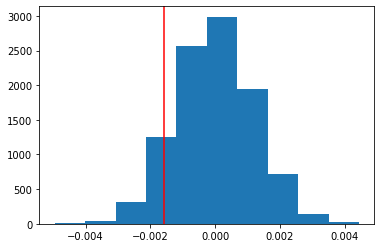

In [31]:
# Plotted a histogram of the p_diffs with a line indicating the statistic difference
plt.hist(p_diffs);
plt.axvline(cr_diff,c='r');

The plot of the `simulated difference` looked like what was expected, which is a `normal distribution`

j. The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**:

In [32]:
# calcualated the p-value of the null distribution
(np.array(p_diffs) > cr_diff).mean()

0.906

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

`CONCLUSION`\
In the above cell, the probability of obtaining a page difference from the `null distribution` that is greater than the statistic page difference was computed. \
This is called the **p-value** of the distribution. Since the p-value **(0.9048)** is greater than **0.05** `type I error` (our accepted error), it means **I fail to reject the** `Null hypothensis`

l. Used a built in model to achieve what was done in `a.` through `j.` Where `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = (df2['landing_page'] == 'old_page').sum()
n_new = (df2['landing_page'] == 'new_page').sum()
print(convert_old, convert_new , n_old, n_new)

17489 17264 145274 145311


m. Now used `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is the link used for using the in built.

In [34]:
z_test, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_test, p_value


(-1.3116075339133115, 0.905173705140591)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The `z-score` (**-1.3116**) and `p-value` (**0.9052**) obtained with the `stats.proportions_ztest` means **I fail to reject** the `Null hypothensis` and this is in alin that initially found

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I'm trying to see if the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since each row is either a conversion or no conversion, it implies that the data is `categorical`, so a **Logistic Regression** will be used

b. The goal was to use **statsmodels** to fit the **Logistic regression** model to see if there is a significant difference in conversion based on which page a customer receives.  However, I first needed to create a column for the intercept, and create a dummy variable column for which page each user received.  Added an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Creation of intercept and dummy data
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['landing_page'])['new_page']

c. Used **statsmodels** to import `Logistic regression model`.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
Log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = Log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provided the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2020-06-04 17:28 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

`ANSWER`:\
The `p-value` associated with the `ab_page` is **0.1897**\
This `p-value` differ from that in `Part II` because;\
The `Null hypotensis` of the regression states that there is no difference in the conversion rate between the new and old page, but its `Alternative`, states that there is difference in their conversion rate

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

`ANSWER`:\
I considering other things that might influence whether or not an individual converts is because of factors like the location of the users and also Change Aversion and Novelly effect

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
# Read the countries data frame and store it on countries_df
countries_df = pd.read_csv('./countries.csv')
# merge countries_df to df2 based on common rows, stored it on df_new and displayed few lines
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [39]:
# check the for the unique countries in the data frame
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [40]:
# Created the necessary dummy variables, fit linear model and displayed result summary
df_new[['CA','UK','US']] =pd.get_dummies(df_new['country'])
Log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','CA','UK']])
result = Log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.3782
Date:               2020-06-04 17:28 BIC:              212823.6968
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.17584    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7629  0.0000  -2.0067  -1.9718
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5159  0.1296  -0.0934   0.0119
UK            0.0099    0.0133     0.7437  0.4570  -0.0162   0.0359
==================================================================

"""

In [41]:
# Converted result from exponential multiple to actual multiple
1/np.exp(-0.0150),1/np.exp(-0.0408),np.exp(0.0099)

(1.015113064615719, 1.0416437559600236, 1.0099491671175422)

`Interpretation of Result`:\
For each one unit decrease in the number of new page assigned, conversion is 1.0151 likely to happen, holding all else constant\
Conversion is 1.0416 likely to happpen from users in the US than CA, holding all else constant\
Conversion is 1.0099 likely to happpen from users in the UK than US, holding all else constant

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# Created interaction column between country and page
df_new['CA_new_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_new_page'] = df_new['UK']*df_new['ab_page']

In [43]:
# Fit Your Linear Model And Obtain the Results
Log_mod = sm.Logit(df_new['converted'], df_new[['intercept','CA_new_page','UK_new_page','CA','UK']])
result = Log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212783.1805
Date:               2020-06-04 17:28 BIC:              212836.0787
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           4                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.27294    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3154  0.0000  -2.0101  -1.9833
CA_new_page  -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
UK_new_page   0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0073    0.0371    -0.1962  0.8445  -0.0799   0.0654
UK            0.0045    0.0175     0.2575  0.7968  -0.0298   0.0389
==================================================================

"""

In [44]:
# Converted result from exponential multiple to actual multiple 
1/np.exp(-0.0674),np.exp(0.0108),1/np.exp(-0.0073),np.exp(0.0045)

(1.0697232819209153, 1.010858530520097, 1.0073267099546657, 1.0045101402046013)

`Interpretation of Result`:\
Conversion is 1.0070 likely to happpen from new page users in the US than in CA, holding all else constant\
Conversion is 1.0109 likely to happpen from new page users in the UK than in US, holding all else constant\
Conversion is 1.0073 likely to happpen from users in the US than CA, holding all else constant\
Conversion is 1.0045 likely to happpen from users in the UK than US, holding all else constant

In [45]:
# Test the accuracy of the logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix

In [46]:
#split the data
x = df_new[['CA_new_page','UK_new_page','CA','UK']]
y = df_new['converted']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)
Log_mod = LogisticRegression()
Log_mod.fit(x_train,y_train)
y_pred = Log_mod.predict(x_test)
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))



C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0
0.0
0.8792091814787412


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


`Interpretation of Result`:\
The `precision` of the regression model is **0.0**, its `recall` is **0.0** while its `accuracy` is **0.879**

In [47]:
confusion_matrix(y_test,y_pred)

array([[51097,     0],
       [ 7020,     0]], dtype=int64)

`Interpretation of Result`:\
Therefore, there are 51097 non-conversion we predicted as non-conversion\
There are 0 non-conversion we predicted as conversion\
There are 7020 conversion we predicted as non-conversion\
and finally, there are 0 conversion we predicted as conversion\
**NOTE**: This implies that the logistic regression is not suitabe for predictions

<a id='conclusions'></a>
## Conclusions

Considering `part I and II` of the analysis carried out, it could be concluded that the old page had a slight better conversion rate that the new page. Moving to the last part of the analysis, it concluded me concluded that the location of the users also have influence on the conversion rate.\
Since our analysis has `timestamp`, prehaps running the test for a longer time could yield as different result because of aversion effect.\
But with the provide data and the statistics obtained from it, practically, it would be best to **keep** the `old page` of the e-commercial website.


### Reference
[Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is the link used for using the in built proportions_ztest.
